## ROC (Local Hough Transformation on spectrograms)

This program plots the ROC curves for the 4 paramters used to generate the final output image.

In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from scipy import misc
import imageio
from sklearn.metrics import auc
from sklearn import metrics
import math
import random
from scipy import stats
import sklearn
from sklearn.metrics import accuracy_score

In [3]:
pi=math.pi
tan=math.tan
cos=math.cos
sin=math.sin
exp=math.exp
sqrt=math.sqrt

In [4]:
image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
freq_min=10
freq_max=image.shape[1]
t_min=10
t_max=image.shape[0]
mean_life=15

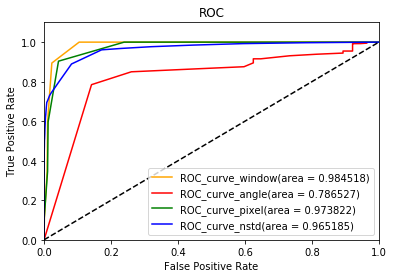

In [27]:
fig=5
accuracy_hist=[]
start=time.time()
angle_limit=20
pixel_limit=10
window_limit=20
nstd_limit=4
TPR_avg_window=np.zeros(shape=window_limit)
FPR_avg_window=np.zeros(shape=window_limit)
TPR_avg_angle=np.zeros(shape=angle_limit)
FPR_avg_angle=np.zeros(shape=angle_limit)
TPR_avg_pixel=np.zeros(shape=pixel_limit)
FPR_avg_pixel=np.zeros(shape=pixel_limit)
TPR_avg_std=np.zeros(shape=nstd_limit*10)
FPR_avg_std=np.zeros(shape=nstd_limit*10)

for N in range(fig):
    
    alpha=random.uniform(0.959931,1.39626) #The angle made by the generated line(between 20 and 70 degrees)
    SNR=2.5
    sigma=0.5
    w0=random.randint(freq_min,15)
    t0=random.randint(t_min,15)

    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)
    pixel_gray=get_gray(pixel)
    th_true=np.mean(pixel)+np.std(pixel)
    binary_gray=get_binary_gray(pixel_gray,th_true)
    img=get_pixel_new(pixel_gray)
    
    #plt.figure(figsize=(11,11))
    #plt.subplot(121), plt.imshow(binary_gray,origin='lower'),plt.title('True Binary Image')
    #plt.subplot(122),plt.imshow(img,origin='lower'),plt.title('Noisy Image')
    #plt.show()
    
    #Threshold on the window size
    
    TPR_matrix=np.zeros(shape=window_limit)
    FPR_matrix=np.zeros(shape=window_limit)
    angle_dim=2
    n_std=2.5
    
    for window_size in range(window_limit):
        pixel_threshold=int((window_size)/2)
        binary_img, binary_final = local_hough_track_reconstruction(img, window_size, angle_dim, pixel_threshold, n_std)
        TPR,FPR=get_positive_rates(binary_gray,binary_final)
        TPR_matrix[window_size]=TPR
        FPR_matrix[window_size]=FPR
    
   
    TPR_matrix=(TPR_matrix-np.min(TPR_matrix))/(np.max(TPR_matrix)-np.min(TPR_matrix))
    FPR_matrix=(FPR_matrix-np.min(FPR_matrix))/(np.max(FPR_matrix)-np.min(FPR_matrix))
    TPR_avg_window=TPR_avg_window+TPR_matrix
    FPR_avg_window=FPR_avg_window+FPR_matrix
    
   #Threshold on n_std
    
    TPR_matrix=np.zeros(shape=nstd_limit*10)
    FPR_matrix=np.zeros(shape=nstd_limit*10)
    n_std=0
    pixel_threshold=3
    angle_dim=2
    window_size=7
    
    while(n_std<=nstd_limit):
        binary_img, binary_final = local_hough_track_reconstruction(img, window_size, angle_dim, pixel_threshold, n_std)
        TPR,FPR=get_positive_rates(binary_gray,binary_final)
        TPR_matrix[int(n_std*10)]=TPR
        FPR_matrix[int(n_std*10)]=FPR
        n_std=n_std+0.1
        
    TPR_matrix=(TPR_matrix-np.min(TPR_matrix))/(np.max(TPR_matrix)-np.min(TPR_matrix))
    FPR_matrix=(FPR_matrix-np.min(FPR_matrix))/(np.max(FPR_matrix)-np.min(FPR_matrix))
    TPR_avg_std=TPR_avg_std+TPR_matrix
    FPR_avg_std=FPR_avg_std+FPR_matrix
    
    #Threshold on pixel
    
    TPR_matrix=np.zeros(shape=pixel_limit)
    FPR_matrix=np.zeros(shape=pixel_limit)
    n_std=n_std=2.5
    angle_dim=2
    window_size=7
    pixel_count=0
    
    for pixel_count in range(pixel_limit):
        binary_img, binary_final = local_hough_track_reconstruction(img, window_size, angle_dim, pixel_count,n_std)
        TPR,FPR=get_positive_rates(binary_gray,binary_final)
        TPR_matrix[pixel_count]=TPR
        FPR_matrix[pixel_count]=FPR
        
    TPR_matrix=(TPR_matrix-np.min(TPR_matrix))/(np.max(TPR_matrix)-np.min(TPR_matrix))
    FPR_matrix=(FPR_matrix-np.min(FPR_matrix))/(np.max(FPR_matrix)-np.min(FPR_matrix))
    TPR_avg_pixel=TPR_avg_pixel+TPR_matrix
    FPR_avg_pixel=FPR_avg_pixel+FPR_matrix
    
    #Threshold on angle_dim
    
    TPR_matrix=np.zeros(shape=angle_limit)
    FPR_matrix=np.zeros(shape=angle_limit)
    n_std=2.5
    pixel_threshold=3
    window_size=7
    
    for angle_count in range(0,angle_limit):
        binary_img, binary_final = local_hough_track_reconstruction(img, window_size, angle_count,pixel_threshold,n_std)
        TPR,FPR=get_positive_rates(binary_gray,binary_final)
        TPR_matrix[angle_count]=TPR
        FPR_matrix[angle_count]=FPR
    
    TPR_matrix=(TPR_matrix-np.min(TPR_matrix))/(np.max(TPR_matrix)-np.min(TPR_matrix))
    FPR_matrix=(FPR_matrix-np.min(FPR_matrix))/(np.max(FPR_matrix)-np.min(FPR_matrix))
    TPR_avg_angle=TPR_avg_angle+TPR_matrix
    FPR_avg_angle=FPR_avg_angle+FPR_matrix
    
                       
TPR_avg_window=TPR_avg_window/fig
FPR_avg_window=FPR_avg_window/fig
TPR_avg_window.sort()
FPR_avg_window.sort()
TPR_avg_angle=TPR_avg_angle/fig
FPR_avg_angle=FPR_avg_angle/fig
TPR_avg_angle.sort()
FPR_avg_angle.sort()
TPR_avg_pixel=TPR_avg_pixel/fig
FPR_avg_pixel=FPR_avg_pixel/fig
TPR_avg_pixel.sort()
FPR_avg_pixel.sort()
TPR_avg_std=TPR_avg_std/fig
FPR_avg_std=FPR_avg_std/fig
TPR_avg_std.sort()
FPR_avg_std.sort()
roc_area_window = auc(FPR_avg_window,TPR_avg_window)
roc_area_angle = auc(FPR_avg_angle,TPR_avg_angle)
roc_area_pixel = auc(FPR_avg_pixel,TPR_avg_pixel)
roc_area_std = auc(FPR_avg_std,TPR_avg_std)
plt.plot(FPR_avg_window,TPR_avg_window,color='orange',label='ROC_curve_window(area = %f)' % roc_area_window)
plt.plot(FPR_avg_angle,TPR_avg_angle,color='red',label='ROC_curve_angle(area = %f)' % roc_area_angle)
plt.plot(FPR_avg_pixel,TPR_avg_pixel,color='green',label='ROC_curve_pixel(area = %f)' % roc_area_pixel)
plt.plot(FPR_avg_std,TPR_avg_std,color='blue',label='ROC_curve_nstd(area = %f)' % roc_area_std)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
    
   # accuracy=get_accuracy(binary_gray,binary_final)
   # accuracy_hist.append(accuracy)

#get_accuracy_hist(accuracy_hist,fig)

In [5]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    SNR=2.0
    
    while(True):
        scatter_time=math.floor(t_prev+np.random.exponential(mean_life))  #Scattering times follow an exponential distribution
       # scatter_time=random.randint(t_prev+mean_life,t_prev+3*mean_life) 
        scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
        if((scatter_time>=t_max)or(scatter_freq>=freq_max)):
            break
            
        ybar=freq_prev
        xbar=t_prev
    
        for i in range(t_prev,scatter_time):
            for j in range(freq_prev,scatter_freq):
                intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
                image[j,i]=(intensity,intensity,0)
                
        t_prev=scatter_time+1
        freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    #print("Time:get_image()",end-start)
    return image

In [6]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [7]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
   # print("Time:get_gray()",end-start)
    return pixel_gray

In [8]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
   # print("Time:get_binary_gray",end-start)
    return binary_gray

In [9]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
   # print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [10]:
def get_voting(img, xx, yy, window, angles):
    
    #plt.imshow(window)
    #plt.show()
    
    #m_x=ma.masked_array(xx, mask=np.invert(window))
    #m_y=ma.masked_array(yy, mask=np.invert(window))
    
    #result=m_x*np.cos(angles[:,None,None])+m_y*np.sin(angles[:,None,None])
    result=xx*np.cos(angles[:,None,None])+yy*np.sin(angles[:,None,None])

    voting_matrix = np.zeros(shape=result.shape, dtype=bool)
    
    #bool_mask = (~result.mask)&(np.abs(result)<0.5)
    bool_mask = window[None,:,:]&(np.abs(result)<0.5)
    #bool_mask = np.abs(result)<0.5

    voting_matrix[bool_mask]=1

    return voting_matrix

In [11]:
def get_local_result(binary_result, pixel_threshold):
    
    hist = np.sum(binary_result,axis=(1,2))
    #plt.plot(hist)
    #plt.show()
    result_angles = hist>pixel_threshold

    return np.any(binary_result[result_angles],axis=0)

In [12]:
def get_window_centers(binary_img, width):
    ind = np.argwhere(binary_img)
    ind_c=(ind[:,0]>=width)&(ind[:,0]<binary_img.shape[0]-width)&\
            (ind[:,1]>=width)&(ind[:,1]<binary_img.shape[1]-width)
    ind = ind[ind_c]
    return ind

In [13]:
def get_binary_img(img,n_std):
    threshold = np.mean(img)+n_std*np.std(img)
    binary_img = img>threshold
    return binary_img

In [14]:
def local_hough_track_reconstruction(img, window_size, angle_dim, pixel_threshold, n_std):

    width = int(window_size/2)

    binary_img = get_binary_img(img,n_std)
    binary_final = np.zeros(shape=binary_img.shape, dtype=bool)
    
    angles = np.linspace(0,np.pi/2,angle_dim)

    ind = get_window_centers(binary_img, width)
    
    x = np.arange(-width, width+1, 1)
    y = np.arange(-width, width+1, 1)
    xx, yy = np.meshgrid(x,y)

    for k in range(ind.shape[0]):

        i=ind[k,0]
        j=ind[k,1]

        x_min = i-width
        x_max = i+width+1
        y_min = j-width
        y_max = j+width+1
    
        window = binary_img[x_min:x_max,y_min:y_max]

       # start=time.time()
        binary_result = get_voting(binary_img, xx, yy, window, angles)
       # end=time.time()
       # print(end-start)
        #print(binary_result[0])
        #plt.imshow(binary_result[10].transpose())
        #plt.show()
        hist = np.sum(binary_result,axis=(1,2))
        #plt.plot(hist)
        #plt.show()
        result_angles = hist>pixel_threshold

        local_result = get_local_result(binary_result,pixel_threshold)

        binary_final[x_min:x_max,y_min:y_max] = binary_final[x_min:x_max,y_min:y_max]|local_result


    return binary_img, binary_final

In [15]:
def get_accuracy(binary_true,reverse_hough):
    accuracy=np.zeros(shape=(binary_true.shape[0],binary_true.shape[1]))
    for i in range(binary_true.shape[0]):
        for j in range(binary_true.shape[1]):
            if(binary_true[i,j]==reverse_hough[i,j]):
                accuracy[i,j]=1
    accuracy_percentage=np.sum(accuracy)/(binary_true.shape[0]*binary_true.shape[1])            
    
    return accuracy_percentage

In [16]:
def get_accuracy_hist(accuracy_hist,N):
    x=np.arange(1,N+1)
    plt.hist(accuracy_hist,N)
   # plt.plot(x,accuracy_hist)
    #plt.ylim([0.95,1.00])
    plt.xlabel('Accuracy')
    plt.ylabel('Cases') 
    plt.show()

In [17]:
def get_positive_rates(binary_gray,binary_final):
    y_true=binary_gray.flatten()
    y_pred=binary_final.flatten()
    TN=0
    FN=0
    TP=0
    FP=0
    
    for k in range(binary_gray.shape[0]*binary_gray.shape[1]):
        if(y_true[k]==1 and y_pred[k]==1):
            TP=TP+1
                    
        if(y_true[k]==1 and y_pred[k]==0):
            FN=FN+1
                        
        if(y_true[k]==0 and y_pred[k]==0):
            TN=TN+1
               
        if(y_true[k]==0 and y_pred[k]==1):
            FP=FP+1 
        
    TPR=TP/(TP+FN)
    if(FP+TN==0):
        FPR=0
        TPR=1
        return TPR,FPR
    FPR=FP/(FP+TN)
    
    return TPR,FPR

In [38]:
for i in range(1,4,0):
    print (i)

ValueError: range() arg 3 must not be zero

In [33]:
np.pi/2

1.5707963267948966